In [48]:
import json
import os
import pandas as pd
import tarfile

# checks from https://wiki.hl7.org/FHIR_NPM_Package_Spec
def check_for_required_json_files(package):
    if not "package/package.json" in package.getnames():
        return "missing package.json"
    
    elif not "package/.index.json" in package.getnames():
        return "missing index.json"

    return "passed"

def check_package_file_content(package):
    manifest = package.extractfile("package/package.json")
    manifest_text = json.loads(manifest.read())
    mandatory_keys = ['name','version','description','dependencies','author']
    if not set(mandatory_keys).issubset(set(manifest_text.keys())):
        return "missing mandatory manifest key", []
    
    dependencies = list(manifest_text['dependencies'].keys())
    return "passed", dependencies

def check_resources(package, resources, resource_types):
    # more care needed here. some are examples or other non-dependency files
    for json_file in package.getnames():
        if not json_file in ["package/package.json","package/.index.json"]:
            string = json_file.strip("package/").strip(".json")
            if "/" not in string:
                resources.append(string)
                try:
                    resource = package.extractfile(json_file)
                    resource_text = json.loads(resource.read())
                    resource_types.append(resource_text['resourceType'])
                except:
                    resource_types.append("Not an actual resource")
    if len(resources) == 0:
        return "no dependencies", [], []
    return "passed", resources, resource_types

def validatePackages():
    all_packages = os.listdir('../output')
    package_meta = pd.DataFrame(columns=['package_name', "status", "dependencies"])
    for package_name in all_packages:
        package_dependencies = [] 
        package_resources = []
        package_resource_types = []

        try:
            package = tarfile.open(f"../output/{package_name}")
            # check to make sure the package has the required json files
            status = check_for_required_json_files(package)
            if status == "passed":
                # check to make sure the package.json has the correct fields
                status, package_dependencies = check_package_file_content(package)
            if status == "passed":
                # find the resources of each package
                status, package_resources, package_resource_types = check_resources(package,
                                                                                    package_resources,
                                                                                    package_resource_types)
            # find packages in the folder that aren't found in the description
            if status == "passed":
                if len(package_dependencies) == 0:
                    status = f"no dependencies found"
            # add name, status, and dependencies to meta
            package_meta = package_meta.append({"package_name":package_name,
                                                "status":status, 
                                                "dependencies":package_dependencies,
                                                "resources":package_resources,
                                                "resource_types": package_resource_types},
                                            ignore_index=True)
            package.close()
        except:
            # this is where the broken packages go to be forgotten forever
            package_meta = package_meta.append({"package_name":package_name, 
                                                "status":"broken_package",
                                                "dependencies":package_dependencies},
                                                ignore_index=True)
    # save the package metadata
#     if not os.path.exists("metadata"):
#         os.mkdir("metadata")
    return package_meta

In [19]:
validatePackages()

,package_name,status,dependencies,resource_types,resources
0,Adapting Clinical Guidelines for the Digital A...,missing index.json,[],[],[]
1,AdverseDrugEventHypoglycemia.tgz,passed,"[hl7.fhir.r4.core, hl7.fhir.us.core, us.nlm.vsac]","[ImplementationGuide, ImplementationGuide, Str...","[ig-r4, ImplementationGuide-hl7.fhir.us.ade-hy..."
2,AffiliateIG.tgz,passed,"[hl7.fhir.r4.core, ehealthplatform.be.r4.feder...","[ImplementationGuide, ImplementationGuide, Car...","[ig-r4, ImplementationGuide-hl7.country.fhir.i..."
3,ANC_CDS.tgz,passed,"[hl7.fhir.r4.core, hl7.fhir.uv.cpg]","[ImplementationGuide, ImplementationGuide, Car...","[ig-r4, ImplementationGuide-fhir.who.anc-cd, C..."
4,ApplicationDataExchangeAssessmentFrameworkandF...,passed,[hl7.fhir.r4.core],"[ImplementationGuide, ImplementationGuide, Str...","[ig-r4, ImplementationGuide-hl7.fhir.uv.mhealt..."
...,...,...,...,...,...
253,WomensHealthTechnologyCoordinatedRegistryNetwo...,missing index.json,[],[],[]
254,WoundAssessmentImplementationGuide.tgz,passed,"[hl7.fhir.r4.core, hl7.fhir.us.core]","[ImplementationGuide, ImplementationGuide, Str...","[ig-r4, ImplementationGuide-hl7.fhir.us.wounda..."
255,XeHealthImplementationGuide.tgz,passed,"[hl7.fhir.r4.core, hl7.fhir.uv.ips]","[ImplementationGuide, ImplementationGuide, Str...","[ig-r4, ImplementationGuide-hl7.eu.fhir.xeh, S..."
256,YourComputableContentIGNameHere.tgz,passed,[hl7.fhir.r4.core],"[ImplementationGuide, ImplementationGuide, Pla...","[ig-r4, ImplementationGuide-example.fhir.uv.co..."


In [7]:
all_packages = os.listdir('../output')
package_meta = pd.DataFrame(columns=['package_name', "status", "dependencies"])
for package_name in all_packages:
    package_dependencies = [] 
    package_resources = []
    package_resource_types = []

In [10]:

package = tarfile.open(f"../output/{package_name}")
# check to make sure the package has the required json files
status = check_for_required_json_files(package)
if status == "passed":
    # check to make sure the package.json has the correct fields
    status, package_dependencies = check_package_file_content(package)
print("checking resources")
if status == "passed":
    # find the resources of each package
    status, package_resources, package_resource_types = check_resources(package,
                                                                        package_resources,
                                                                        package_resource_types)


checking resources


In [11]:
package

In [12]:
    status, package_resources, package_resource_types = check_resources(package,
                                                                        package_resources,
                                                                        package_resource_types)

In [13]:
status

'passed'

In [14]:
package_resources

['ig-r4',
 'ImplementationGuide-example.fhir.uv.mycontentig',
 'Library-retrieve-example',
 'Library-extension-and-slicing-example',
 'Library-first-example',
 'Library-dependency-example',
 'ig-r4',
 'ImplementationGuide-example.fhir.uv.mycontentig',
 'Library-retrieve-example',
 'Library-extension-and-slicing-example',
 'Library-first-example',
 'Library-dependency-example']

In [15]:
package_resource_types

['ImplementationGuide',
 'ImplementationGuide',
 'Library',
 'Library',
 'Library',
 'Library',
 'ImplementationGuide',
 'ImplementationGuide',
 'Library',
 'Library',
 'Library',
 'Library']

In [56]:
package_meta = pd.read_csv("../metadata/metadata_og.csv")

In [57]:
['; '.join(map(str, l)) for l in package_meta['dependencies']]

['[; ]',
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ,;  ; '; h; l; 7; .; f; h; i; r; .; u; s; .; c; o; r; e; '; ,;  ; '; u; s; .; n; l; m; .; v; s; a; c; '; ]",
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ,;  ; '; e; h; e; a; l; t; h; p; l; a; t; f; o; r; m; .; b; e; .; r; 4; .; f; e; d; e; r; a; l; p; r; o; f; i; l; e; s; '; ]",
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ,;  ; '; h; l; 7; .; f; h; i; r; .; u; v; .; c; p; g; '; ]",
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ]",
 '[; ]',
 '[; ]',
 '[; ]',
 '[; ]',
 '[; ]',
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ]",
 '[; ]',
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ,;  ; '; f; e; d; .; b; e; .; c; o; r; e; '; ]",
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ]",
 '[; ]',
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ]",
 '[; ]',
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ,;  ; '; h; l; 7; .; f; h;

In [63]:
['; '.join(map(str, l)) for l in package_meta['dependencies']]

['[; ]',
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ,;  ; '; h; l; 7; .; f; h; i; r; .; u; s; .; c; o; r; e; '; ,;  ; '; u; s; .; n; l; m; .; v; s; a; c; '; ]",
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ,;  ; '; e; h; e; a; l; t; h; p; l; a; t; f; o; r; m; .; b; e; .; r; 4; .; f; e; d; e; r; a; l; p; r; o; f; i; l; e; s; '; ]",
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ,;  ; '; h; l; 7; .; f; h; i; r; .; u; v; .; c; p; g; '; ]",
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ]",
 '[; ]',
 '[; ]',
 '[; ]',
 '[; ]',
 '[; ]',
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ]",
 '[; ]',
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ,;  ; '; f; e; d; .; b; e; .; c; o; r; e; '; ]",
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ]",
 '[; ]',
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ]",
 '[; ]',
 "[; '; h; l; 7; .; f; h; i; r; .; r; 4; .; c; o; r; e; '; ,;  ; '; h; l; 7; .; f; h;

In [69]:
package_meta['dependencies'].replace(",",";")

0                                                     []
1      ['hl7.fhir.r4.core', 'hl7.fhir.us.core', 'us.n...
2      ['hl7.fhir.r4.core', 'ehealthplatform.be.r4.fe...
3                ['hl7.fhir.r4.core', 'hl7.fhir.uv.cpg']
4                                   ['hl7.fhir.r4.core']
                             ...                        
253                                                   []
254             ['hl7.fhir.r4.core', 'hl7.fhir.us.core']
255              ['hl7.fhir.r4.core', 'hl7.fhir.uv.ips']
256                                 ['hl7.fhir.r4.core']
257    ['hl7.fhir.r4.core', 'example.fhir.uv.myig', '...
Name: dependencies, Length: 258, dtype: object

In [77]:
[''.join(map(lambda x: x.replace(",",";"), l)) for l in package_meta['dependencies']]

['[]',
 "['hl7.fhir.r4.core'; 'hl7.fhir.us.core'; 'us.nlm.vsac']",
 "['hl7.fhir.r4.core'; 'ehealthplatform.be.r4.federalprofiles']",
 "['hl7.fhir.r4.core'; 'hl7.fhir.uv.cpg']",
 "['hl7.fhir.r4.core']",
 '[]',
 '[]',
 '[]',
 '[]',
 '[]',
 "['hl7.fhir.r4.core']",
 '[]',
 "['hl7.fhir.r4.core'; 'fed.be.core']",
 "['hl7.fhir.r4.core']",
 '[]',
 "['hl7.fhir.r4.core']",
 '[]',
 "['hl7.fhir.r4.core'; 'hl7.fhir.us.core'; 'hl7.fhir.us.odh']",
 '[]',
 "['hl7.fhir.r4.core']",
 "['hl7.fhir.r4.core']",
 "['hl7.fhir.r4.core']",
 '[]',
 '[]',
 "['hl7.fhir.r3.core']",
 "['hl7.fhir.r3.core']",
 "['hl7.fhir.r4.core'; 'hl7.fhir.us.core']",
 "['hl7.fhir.r4.core'; 'hl7.fhir.us.core']",
 "['hl7.fhir.r4.core'; 'hl7.fhir.us.core']",
 "['hl7.fhir.r4.core']",
 "['hl7.fhir.r4.core'; 'hl7.fhir.us.core']",
 '[]',
 '[]',
 "['hl7.fhir.r4.core'; 'hl7.fhir.uv.cpg'; 'cqf.fhir.common']",
 '[]',
 "['hl7.fhir.r4.core']",
 '[]',
 "['fhir.base.template']",
 "['fhir.base.template']",
 "['hl7.fhir.r4.core'; 'ch.fhir.ig.ch-epr-

In [78]:
package_meta

,Unnamed: 0,package_name,status,dependencies,resource_types,resources
0,0,Adapting Clinical Guidelines for the Digital A...,missing index.json,[],[],[]
1,1,AdverseDrugEventHypoglycemia.tgz,passed,"['hl7.fhir.r4.core', 'hl7.fhir.us.core', 'us.n...","['ImplementationGuide', 'ImplementationGuide',...","['ig-r4', 'ImplementationGuide-hl7.fhir.us.ade..."
2,2,AffiliateIG.tgz,passed,"['hl7.fhir.r4.core', 'ehealthplatform.be.r4.fe...","['ImplementationGuide', 'ImplementationGuide',...","['ig-r4', 'ImplementationGuide-hl7.country.fhi..."
3,3,ANC_CDS.tgz,passed,"['hl7.fhir.r4.core', 'hl7.fhir.uv.cpg']","['ImplementationGuide', 'ImplementationGuide',...","['ig-r4', 'ImplementationGuide-fhir.who.anc-cd..."
4,4,ApplicationDataExchangeAssessmentFrameworkandF...,passed,['hl7.fhir.r4.core'],"['ImplementationGuide', 'ImplementationGuide',...","['ig-r4', 'ImplementationGuide-hl7.fhir.uv.mhe..."
...,...,...,...,...,...,...
253,253,WomensHealthTechnologyCoordinatedRegistryNetwo...,missing index.json,[],[],[]
254,254,WoundAssessmentImplementationGuide.tgz,passed,"['hl7.fhir.r4.core', 'hl7.fhir.us.core']","['ImplementationGuide', 'ImplementationGuide',...","['ig-r4', 'ImplementationGuide-hl7.fhir.us.wou..."
255,255,XeHealthImplementationGuide.tgz,passed,"['hl7.fhir.r4.core', 'hl7.fhir.uv.ips']","['ImplementationGuide', 'ImplementationGuide',...","['ig-r4', 'ImplementationGuide-hl7.eu.fhir.xeh..."
256,256,YourComputableContentIGNameHere.tgz,passed,['hl7.fhir.r4.core'],"['ImplementationGuide', 'ImplementationGuide',...","['ig-r4', 'ImplementationGuide-example.fhir.uv..."


In [110]:
package_meta = pd.read_csv("../metadata/metadata_og.csv")

In [89]:

all_dependencies = []
for i in range(len(package_meta.query("status == 'passed'")['dependencies'])):
    for dependency in package_meta.query("status == 'passed'")['dependencies'].iloc[i]:
        all_dependencies.append(dependency)

dependancies = pd.DataFrame({"dependency": all_dependencies})
dependancies['count'] = 1
dependancies = dependancies.groupby(['dependency'], as_index=False)['count'].sum()
dependancies = dependancies.sort_values("count", ascending=False)

In [94]:
for i in range(len(package_meta.query("status == 'passed'")['dependencies'])):
    for dependency in package_meta.query("status == 'passed'")['dependencies'].iloc[i]:
        print(dependency)

[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
,
 
'
h
l
7
.
f
h
i
r
.
u
s
.
c
o
r
e
'
,
 
'
u
s
.
n
l
m
.
v
s
a
c
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
,
 
'
e
h
e
a
l
t
h
p
l
a
t
f
o
r
m
.
b
e
.
r
4
.
f
e
d
e
r
a
l
p
r
o
f
i
l
e
s
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
,
 
'
h
l
7
.
f
h
i
r
.
u
v
.
c
p
g
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
,
 
'
f
e
d
.
b
e
.
c
o
r
e
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
,
 
'
h
l
7
.
f
h
i
r
.
u
s
.
c
o
r
e
'
,
 
'
h
l
7
.
f
h
i
r
.
u
s
.
o
d
h
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
]
[
'
h
l
7
.
f
h
i
r
.
r
3
.
c
o
r
e
'
]
[
'
h
l
7
.
f
h
i
r
.
r
3
.
c
o
r
e
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
,
 
'
h
l
7
.
f
h
i
r
.
u
s
.
c
o
r
e
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
,
 
'
h
l
7
.
f
h
i
r
.


7
.
f
h
i
r
.
u
s
.
c
o
r
e
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
,
 
'
h
l
7
.
f
h
i
r
.
u
v
.
i
p
s
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
]
[
'
h
l
7
.
f
h
i
r
.
r
4
.
c
o
r
e
'
,
 
'
e
x
a
m
p
l
e
.
f
h
i
r
.
u
v
.
m
y
i
g
'
,
 
'
h
l
7
.
f
h
i
r
.
u
v
.
c
p
g
'
,
 
'
c
q
f
.
f
h
i
r
.
c
o
m
m
o
n
'
]


In [95]:
for i in package_meta.query("status == 'passed'")['dependencies'].iloc[i]

"['hl7.fhir.r4.core', 'example.fhir.uv.myig', 'hl7.fhir.uv.cpg', 'cqf.fhir.common']"

In [99]:
package_meta.iloc[i]['dependencies']

"['hl7.fhir.r4.core']"

In [114]:
package_meta['dependencies'].iloc[1].split(",")

["['hl7.fhir.r4.core'", " 'hl7.fhir.us.core'", " 'us.nlm.vsac']"]

In [109]:
type([])

list

In [122]:
package_meta['dependencies'].iloc[1].strip("[").strip(']').replace("'", "").split(", ")

['hl7.fhir.r4.core', 'hl7.fhir.us.core', 'us.nlm.vsac']

In [132]:
for i in range(0,package_meta.shape[0]):
    package_meta['dependencies'].iloc[i] = package_meta['dependencies'].iloc[i].strip("[").strip(']').replace("'", "").split(", ")

C:\Users\Greg\anaconda3\envs\OMSCS_Python\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [134]:
type(package_meta['dependencies'].iloc[1])


list

In [138]:
package_meta = pd.read_csv("../metadata/metadata_og.csv")

for i in range(0,package_meta.shape[0]):
    package_meta['dependencies'].iloc[i] = package_meta['dependencies'].iloc[i].strip("[").strip(']').replace("'", "").split(", ")
    package_meta['resources'].iloc[i] = package_meta['resources'].iloc[i].strip("[").strip(']').replace("'", "").split(", ")
    package_meta['resource_types'].iloc[i] = package_meta['resource_types'].iloc[i].strip("[").strip(']').replace("'", "").split(", ")


all_resources = []
for i in range(len(package_meta.query("status == 'passed'")['resources'])):
    for resource in package_meta.query("status == 'passed'")['resources'].iloc[i]:
        all_resources.append(resource)

resources = pd.DataFrame({"resource": all_resources})
resources['count'] = 1

C:\Users\Greg\anaconda3\envs\OMSCS_Python\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [140]:
    resources = resources.groupby(['resource'], as_index=False)['count'].sum()
    resources = resources.sort_values("count", ascending=False)

In [143]:
import seaborn as sns

In [144]:
resources.head().barplot(x='resource', y='count')

AttributeError: 'DataFrame' object has no attribute 'barplot'

<AxesSubplot:xlabel='resource', ylabel='count'>

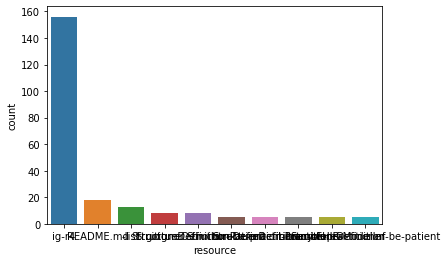

In [147]:
sns.barplot(data=resources.head(10), x='resource', y='count')